In [1]:
# Forecasting AWS Monthly Costs
%pip install prophet pandas matplotlib

Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.
Found files: ['cost_data/unified_cost_analysis_2024_2025_daily_chunks_20250711_184158.csv', 'cost_data/unified_cost_analysis_2024_2025_daily_chunks_20250711_184320.csv']
Combined data: 37999 rows, 18 columns
           ds              y
0  2024-06-30  111223.651925
1  2024-07-31   34762.964127
2  2024-08-31  129475.509362
3  2024-09-30  106354.317051
4  2024-10-31   74196.929622
5  2024-11-30  123785.774570
6  2024-12-31   87730.004211
7  2025-01-31   52747.091451
8  2025-02-28  148177.037701
9  2025-03-31   78422.299030
10 2025-04-30  128853.300329
11 2025-05-31  154418.846522
12 2025-06-30   49510.168108
13 2025-07-31  139253.333140


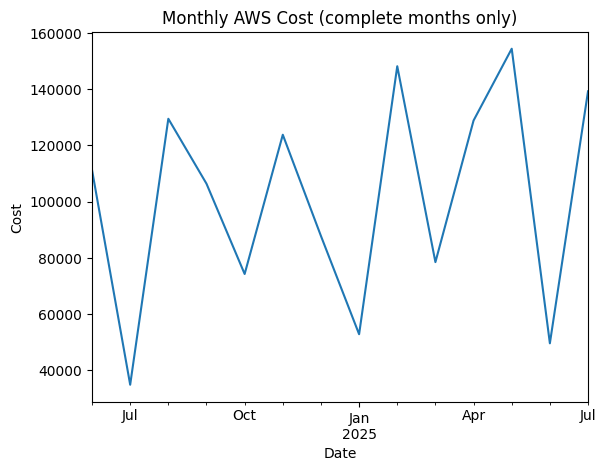

11:42:45 - cmdstanpy - INFO - Chain [1] start processing
11:42:46 - cmdstanpy - INFO - Chain [1] done processing


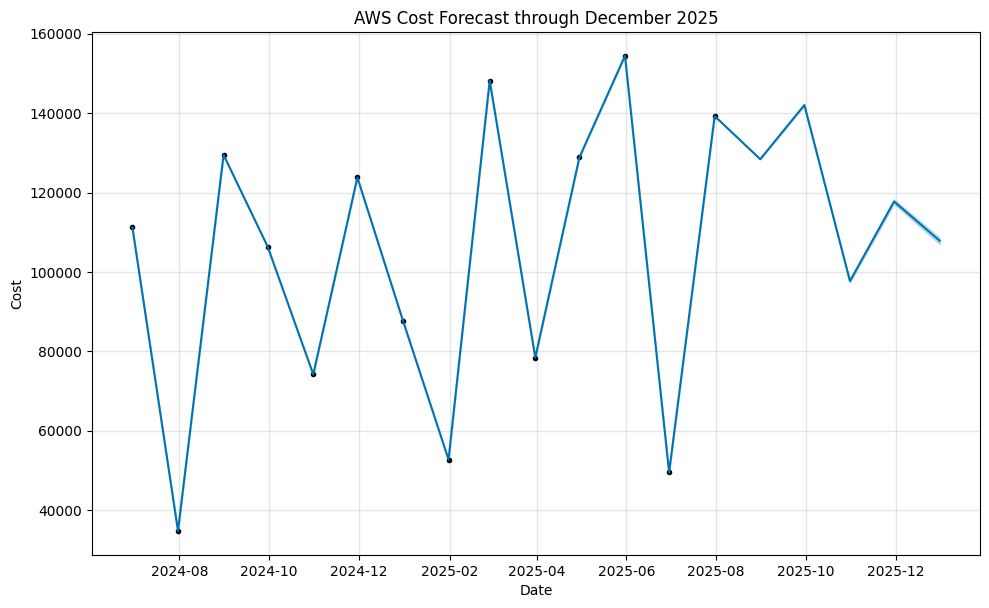

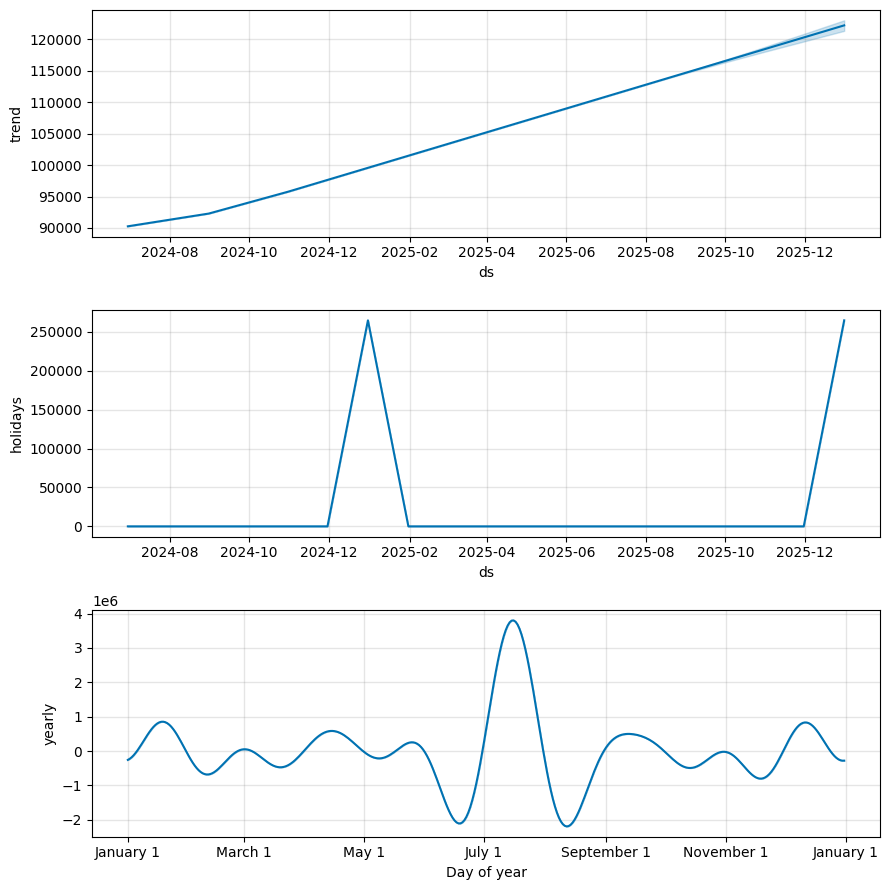

Forecast saved to 'aws_cost_forecast_dec2025.csv'


In [ ]:
# ## 2. Import libraries
import pandas as pd
import glob
from prophet import Prophet
import matplotlib.pyplot as plt

# ## 3. Load and combine daily AWS cost data
file_paths = glob.glob('cost_data/unified_cost_analysis_*.csv')
print(f"Found files: {file_paths}")

dataframes = []
for file_path in file_paths:
    df_temp = pd.read_csv(file_path, parse_dates=['period_start', 'period_end'])
    df_temp = df_temp[df_temp['granularity'] == 'DAILY']
    dataframes.append(df_temp)

df = pd.concat(dataframes, ignore_index=True)
print(f"Combined data: {df.shape[0]} rows, {df.shape[1]} columns")

# ## 4. Filter complete months only
# Count records per month to detect incomplete months
df['month_period'] = df['period_start'].dt.to_period('M')
monthly_counts = df.groupby('month_period').size()
complete_months = monthly_counts[monthly_counts >= 28].index
df = df[df['month_period'].isin(complete_months)]

# ## 5. Aggregate costs by month
cost_col = 'blended_cost'  # could also use 'unblended_cost'
monthly_data = (
    df.set_index('period_start')[cost_col]
      .resample('M').sum().reset_index()
)
monthly_data = monthly_data.rename(columns={'period_start': 'ds', cost_col: 'y'})
print(monthly_data)

# ## 6. Plot historical time series
monthly_data.plot(x='ds', y='y', title='Monthly AWS Cost (complete months only)', legend=False)
plt.ylabel('Cost')
plt.xlabel('Date')
plt.show()

# ## 7. Setup holidays and train Prophet model
# Define special events calendar: Chile Cyber Days 2025 and Christmas
# Adding windows so effects apply to the full month
special_dates = pd.DataFrame({
    'ds': pd.to_datetime([
        "2025-10-06", "2025-10-07", "2025-10-08",  # Chile Cyber Days 2025
        "2024-12-25", "2025-12-25"                    # Christmas 2024 & 2025
    ]),
    'holiday': [
        'CyberDays_2025', 'CyberDays_2025', 'CyberDays_2025',
        'Christmas',   'Christmas'
    ],
    'lower_window': [0, 0, 0, 0, 0],
    'upper_window': [25, 25, 25, 6, 6]
})

model = Prophet(
    growth='linear',
    changepoint_prior_scale=0.05,
    yearly_seasonality=10,
    weekly_seasonality=False,
    daily_seasonality=False,
    seasonality_mode='additive',
    holidays=special_dates
)

model.fit(monthly_data)

# ## 8. Create prediction dataframe through December 2025
# Calculate months from last date to 2025-12-31
last_date = monthly_data['ds'].max()
end_date = pd.Timestamp('2025-12-31')
months_to_predict = (end_date.year - last_date.year) * 12 + (end_date.month - last_date.month)
future_dates = model.make_future_dataframe(periods=months_to_predict, freq='M')

# ## 9. Generate predictions and show results
predictions = model.predict(future_dates)
fig1 = model.plot(predictions)
plt.title('AWS Cost Forecast through December 2025')
plt.xlabel('Date')
plt.ylabel('Cost')
plt.show()

fig2 = model.plot_components(predictions)
plt.tight_layout()
plt.show()

# ## 10. Save predictions to file
predictions[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].to_csv('aws_cost_forecast_dec2025.csv', index=False)
print("Forecast saved to 'aws_cost_forecast_dec2025.csv'")
